The challenge that this notebook is going to tackle is one of image generation The goal of this notebook is to develop a machine learning model that will allow for an image to be created with the style of the painter Monet. The solution outputted by this notebook will be a series of generated images that will be zipped to submit to the challenge. 

The data that is provided by this assignment are two sets of images one set is 300 Monet images with two file formats, jpeg and tfrec and over 7000 no Monet images in the same formats. The data has been provided by the Kaggle challenge (https://www.kaggle.com/competitions/gan-getting-started/data) that is being submitted to, for evaluation. The outputted data needs to be 7,000-10,000 256x256 Monet like jpeg images zipped into a file named images.zip.


As part of EDA, I outputted the Monet image and counts. And the model that was created was a DCGAN, the reason that this was chosen was that due to the wide range of 7,000 – 10,000 images that needed to be submitted then the little over 7,000 images would not be sufficient to satisfy the upper bound so the random input of a DCGAN was preferable in my eyes. The resulting model performed very poorly with images that mainly copied Monet’s color pallet but not discernable objects.

To improve the model the training data of Monet should be augmented with additional data, and a different GAN should be chosen such as a style transfer GAN which would take an existing image as an input and only slightly manipulate the image like a filter instead of trying to generate a full image from scratch. 
atch. 


Found 300 files.


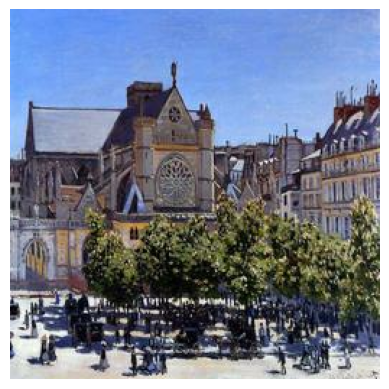

In [16]:
import keras
import tensorflow as tf
from keras import layers
from keras import ops
import os
from zipfile import ZipFile
import matplotlib.pyplot as plt


with ZipFile("./images.zip", "r") as zipobj:
    zipobj.extractall("images")

dataset = keras.utils.image_dataset_from_directory(
    "images", label_mode=None, image_size=(256, 256), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [ ]:
import gdown
discriminator = keras.Sequential(
    [
        keras.Input(shape=(256, 256, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(32 * 32 * 128),
        layers.Reshape((32, 32, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        
        generated_images = self.generator(random_latent_vectors)
        combined_images = ops.concatenate([generated_images, real_images], axis=0)

        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }



class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(42)

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = keras.random.normal(
            shape=(self.num_img, self.latent_dim), seed=self.seed_generator
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        if(epoch % 100 == 0 or epoch > 200):
            for i in range(self.num_img):
                img = keras.utils.array_to_img(generated_images[i])
                img.save("./images/%03d_%d.jpg" % (epoch, i))


epochs = 901  
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)


In [ ]:
import shutil
shutil.make_archive("./", 'zip', "./images")

Code Reference:
https://keras.io/examples/generative/dcgan_overriding_train_step/
https://keras.io/examples/generative/conditional_gan/